# 2D models and transformations

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

In this notebook some basic approaches for 2D model fitting and image alignment are introduced.

## Line fitting

Let us first generate random points from a line $y = 2 x + 1$ and add some noise to these points.

In [3]:
x = np.random.rand(20,1)

In [4]:
y = 2*x + 1 + np.random.randn(20,1)*0.05

Then we define a function that performs least squares line fitting, and use the function to estimate the line parameters (slope, intercept). Notice that the ground truth values are $(2, 1)$.

In [5]:
def linefit(x, y):
    X = np.hstack((x,np.ones_like(x)))
    #B=np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y) #using normal equations
    B = np.matmul(np.linalg.pinv(X),y) # using pseudoinverse
    return B

In [6]:
B=linefit(x,y)

In [7]:
print(B)

[[1.99191124]
 [0.99146048]]


Below we visualize the points and the line estimate obtained. In this case all the points are inliers and they are close to the line. Hence, least squares work perfectly with this kind of data.

In [8]:
x_line = np.linspace(0,1,10)
y_line = B[0]*x_line + B[1]

(1, 3)

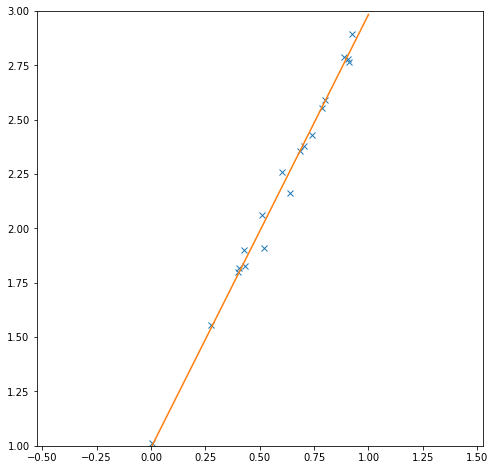

In [9]:
plt.figure(figsize=(8,8))
plt.plot(x,y,'x')
plt.plot(x_line,y_line)
plt.axis('equal')
plt.ylim(1,3)

Next we add one outlier to the data and perform fitting again. Now, we can see that least squares fails because of a single point that does not belong to the line.

In [10]:
x2 = np.vstack((x, 1.4))
y2 = np.vstack((y, 2))

In [11]:
B2=linefit(x2,y2)

In [12]:
x_line2 = np.linspace(0,1.5,10)
y_line2 = B2[0]*x_line2 + B2[1]

(1, 3)

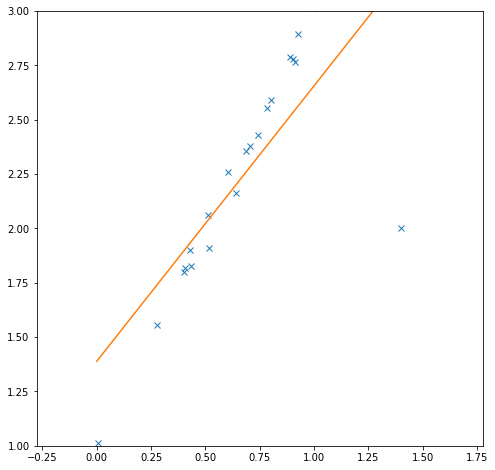

In [13]:
plt.figure(figsize=(8,8))
plt.plot(x2,y2,'x')
plt.plot(x_line2,y_line2)
plt.axis('equal')
plt.ylim(1,3)

## RANSAC

Outliers often exist in the data obtained from images, for example, in edge points. RANSAC is a robust method that can deal with a large proportion of outliers. It is based on minimal sets of randomly sampled points that are fitted to model until a good fit is achieved. The next two functions implement the RANSAC algorithm for line fitting.

In [14]:
def random_sample_and_fit(x, y):
    while True:
        i = np.random.choice(len(x), 2, replace=False)
        xs = x[i]; ys = y[i]
        X = np.hstack((xs,np.ones_like(xs)))
        if np.linalg.det(X) != 0.0:
            break
    B = np.matmul(np.linalg.inv(X),ys)
    return B

In [15]:
def linefit_RANSAC(x, y, N, threshold, num_inliers):
    Bs = []
    for i in range(N):
        B = random_sample_and_fit(x,y)
        Bs.append(B)
        er=y-(B[0]*x+B[1])
        inliers = abs(er)<threshold
        if np.sum(inliers) >= num_inliers:
            B = linefit(x[inliers[:,0]], y[inliers[:,0]])
            return B, Bs
    return False, Bs

Next, we generate a large number of outliers that are combined with the previous data points.

In [16]:
x_out = np.random.rand(30,1)*2
y_out = np.random.rand(30,1)*2 + 1

In [17]:
x3 = np.vstack((x, x_out))
y3 = np.vstack((y, y_out))

In [18]:
i = np.arange(50)
np.random.shuffle(i)
x3 = x3[i]; y3 = y3[i]

Using RANSAC we perform line fitting to these points. The result is illustrated below.

In [19]:
B3, Bs = linefit_RANSAC(x3, y3, 300, 0.1, 20)

In [20]:
x_line3 = np.linspace(0,2,10)
y_line3 = B3[0]*x_line3 + B3[1]

(1, 3)

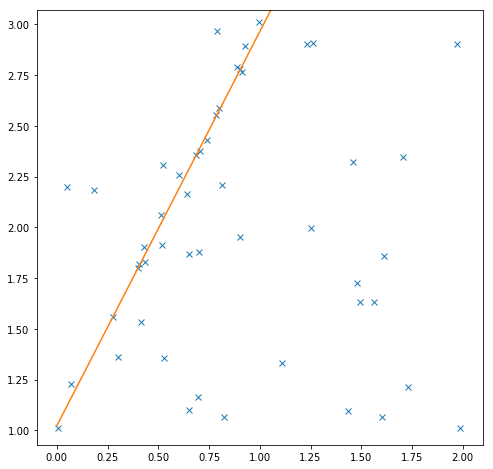

In [21]:
plt.figure(figsize=(8,8))
plt.plot(x3,y3,'x')
plt.plot(x_line3,y_line3)
plt.axis('equal')
plt.ylim(1,3)

We also illustrate all the line hypotheses made by the algorithm below.

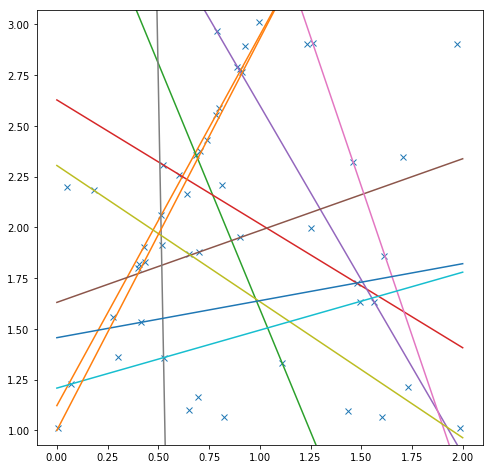

In [22]:
plt.figure(figsize=(8,8))
plt.plot(x3,y3,'x')
plt.axis('equal')
for i in range(len(Bs)):
    y_line3 = Bs[i][0]*x_line3 + Bs[i][1]
    plt.plot(x_line3,y_line3)
    plt.ylim(1,3)
#plt.axis('equal')

This is the final estimate.

In [23]:
print(B3)

[[1.94200735]
 [1.02275044]]


Then we use a real image to extract the edge points and perform line fitting using RANSAC. First, we read the image and visualize it.

In [24]:
img = cv2.imread('images/blox.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

(-0.5, 255.5, 255.5, -0.5)

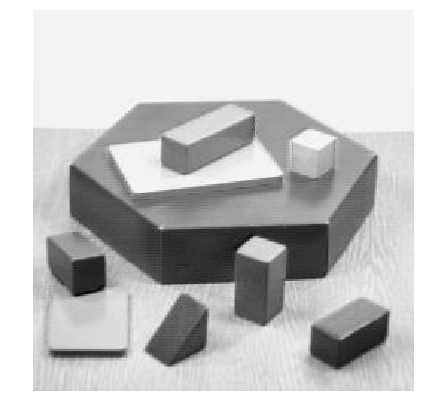

In [25]:
plt.figure(figsize=(7,7))
plt.imshow(img, cmap='gray')
plt.axis('off')

The edge points are extracted using the Canny edge detector. The edge image is shown below.

In [26]:
edges = cv2.Canny(img,100,200)

(-0.5, 255.5, 255.5, -0.5)

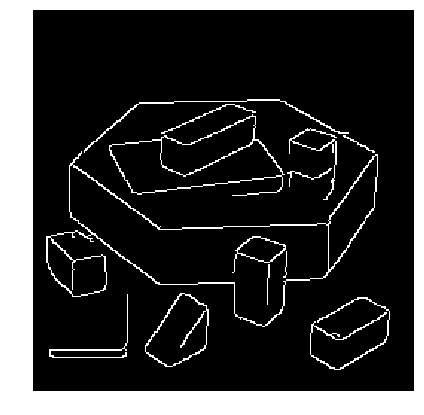

In [27]:
plt.figure(figsize=(7,7))
plt.imshow(edges, cmap='gray')
plt.axis('off')

In [28]:
pt = cv2.findNonZero(edges)

In [29]:
x = pt[:,:,0]; y = pt[:,:,1]

In [30]:
x_line = np.linspace(0,250,30)

We run the RANSAC algorithm 20 times to the edge points in order to find multiple lines. The resulting lines are overlaid on the original image below.

(-0.5, 255.5, 256.0, 0.0)

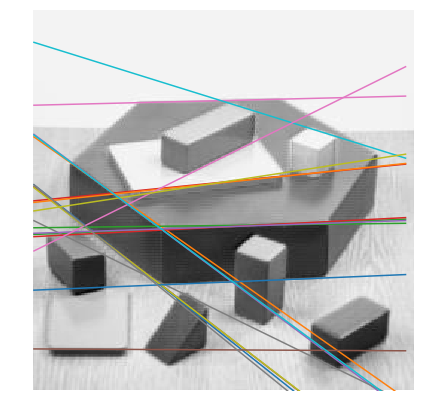

In [31]:
plt.figure(figsize=(7,7))
plt.imshow(img, cmap='gray')
for i in range(20):
    B, Bs = linefit_RANSAC(x, y, 1000, 0.7, 50)
    y_line = B[0]*x_line + B[1]
    plt.plot(x_line, y_line)
plt.ylim(256,0)
plt.axis('off')

## Hough transform
In case of simple parametric models such as lines, Hough transform a good alternative for robust model fitting. Hough line fitting is implemented in OpenCV, and we use it with the same edge data as above.

In [32]:
lines = cv2.HoughLines(edges,1,np.pi/180,50)

In [33]:
len(lines)

31

The lines obtained are visualized below together with the original image.

(0.0, 256.0, 256.0, 0.0)

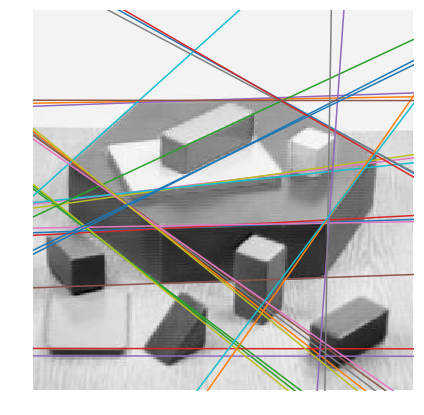

In [34]:
plt.figure(figsize=(7,7))
plt.imshow(img, cmap='gray')
for rho,theta in lines[:,0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 500*(-b))
    y1 = int(y0 + 500*(a))
    x2 = int(x0 - 500*(-b))
    y2 = int(y0 - 500*(a))
    plt.plot((x1, x2), (y1, y2))
plt.ylim(256,0)
plt.xlim(0,256)
plt.axis('off')

## Template matching

Template matching can be used to match a template image with a test image if the geometric transformation between these images can be explained by pure translation. In the following example we demonstrate how it works.

In [35]:
img = cv2.imread('images/board.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
tmpl = cv2.imread('images/template.jpg')
tmpl = cv2.cvtColor(tmpl,cv2.COLOR_BGR2GRAY)

The template is shown on the left and the test image on the right.

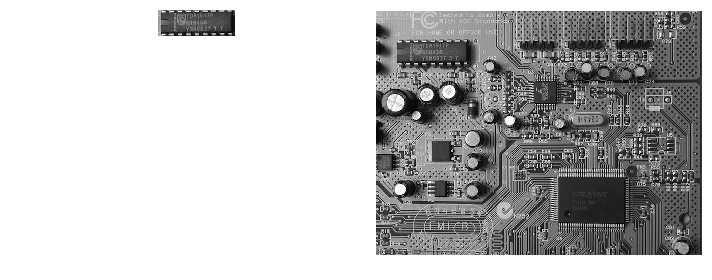

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
ax1.imshow(tmpl, cmap='gray')
ax1.axis('equal')
ax1.axis('off')
ax2.imshow(img, cmap='gray')
ax2.axis('off')
plt.tight_layout()

As a matching criterion we us normalized cross correlation (NCC). In that case the output is a correlation image, where the brightest point (maximum value) indicates the best matching location.

In [37]:
res = cv2.matchTemplate(img,tmpl,cv2.TM_CCORR_NORMED)

(-0.5, 491.5, 429.5, -0.5)

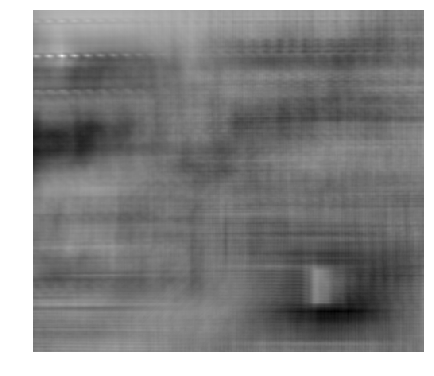

In [38]:
plt.figure(figsize=(7,7))
plt.imshow(res, cmap='gray')
plt.axis('off')

In [39]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

In [40]:
max_val

0.9986540079116821

Finally, we overlay a rectangle to the best matching location and visualize the result.

In [41]:
h, w = tmpl.shape
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

In [42]:
out = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), top_left, bottom_right, [255, 0, 0], 2)

(-0.5, 639.5, 479.5, -0.5)

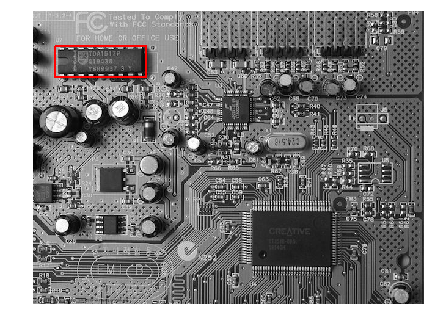

In [43]:
plt.figure(figsize=(7,7))
plt.imshow(out)
plt.axis('off')

## Affine mapping

Template matching cannot be used under general affine transformation. In that case we can perform image alignment by establishing point correspondences between the template image and the test images, and using those correspondences estimate the affine transformation parameters. 

First, we read and visualize the template (left) and the test image (right).

In [44]:
img = cv2.imread('images/box_in_scene.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
tmpl = cv2.imread('images/box.png')
tmpl = cv2.cvtColor(tmpl,cv2.COLOR_BGR2GRAY)

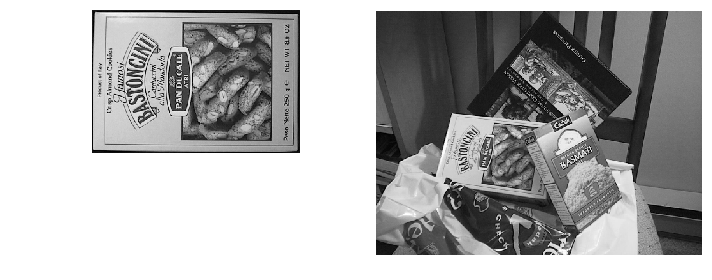

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
ax1.imshow(tmpl, cmap='gray')
ax1.axis('equal')
ax1.axis('off')
ax2.imshow(img, cmap='gray')
ax2.axis('off')
plt.tight_layout()

Then we extract and match SIFT features. To avoid outliers, we use relatively low ratio distance (0.5).

In [46]:
sift = cv2.xfeatures2d.SIFT_create()

In [47]:
kpt, desct = sift.detectAndCompute(tmpl,None)
kpi, desci = sift.detectAndCompute(img,None)

In [48]:
bf = cv2.BFMatcher()

In [49]:
matches = bf.knnMatch(desct,desci, k=2)

In [50]:
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

The matches obtained are visualized below.

In [51]:
out = cv2.drawMatchesKnn(tmpl,kpt,img,kpi,good,None,flags=2)

(-0.5, 835.5, 383.5, -0.5)

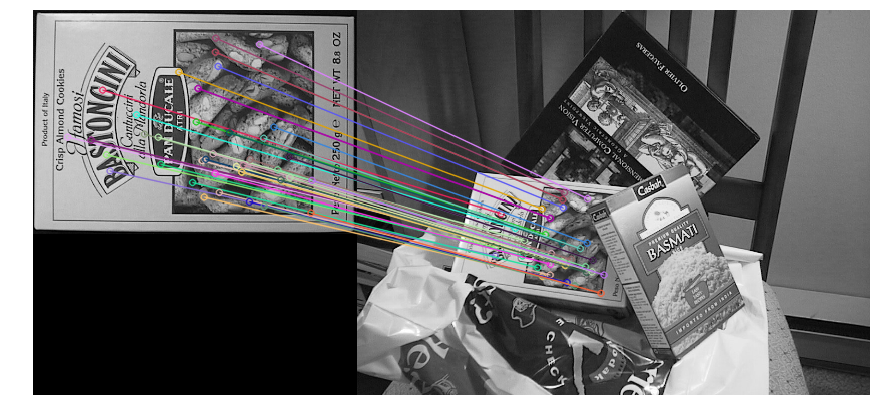

In [52]:
plt.figure(figsize=(15,8))
plt.imshow(out)
plt.axis('off')

Because there were no outliers in the set of point matches, we can use least squares fitting to estimate the affine transformation parameters in the following steps.

In [53]:
pi = np.zeros((len(good), 2))
pt = np.zeros((len(good), 2))
for i in range(len(good)):
    i1 = good[i][0].queryIdx
    i2 = good[i][0].trainIdx
    pi[i,:] = kpi[i2].pt
    pt[i,:] = kpt[i1].pt

In [54]:
n = pi.shape[0]
M = np.zeros((2*n, 6))
b = np.zeros((2*n, 1))

In [55]:
for i in range(n):
    M[i*2,:] = np.array([pt[i,0], pt[i,1], 0, 0, 1, 0])
    M[i*2+1,:] = np.array([0, 0, pt[i,0], pt[i,1], 0, 1])
    b[i*2,0] = pi[i,0]
    b[i*2+1,0] = pi[i,1]

In [56]:
x = np.matmul(np.linalg.pinv(M), b)

We check the quality of the result by calculating the residual error and its standard deviation. We can see that it is clearly less than 1 which indicates that fitting was successful.

In [57]:
er = b - np.matmul(M, x)

In [58]:
np.std(er)

0.7135771793994051

We construct and print the affine transformation matrix.

In [59]:
A = np.array([[x[0,0],x[1,0],x[4,0]],[x[2,0],x[3,0],x[5,0]],[0,0,1]])

In [60]:
print(A)

[[ 5.32553140e-01 -9.58996182e-02  1.11868625e+02]
 [ 6.74450191e-02  5.29839377e-01  1.54481791e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Finally, we warp the template image using the estimated affine transformation, and blend its red channel together with the test image to illustrate how well the images match.

In [61]:
rows,cols = img.shape

In [62]:
dst = cv2.warpAffine(tmpl,A[0:2,:],(cols,rows))

In [63]:
out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)

In [64]:
dst[:,:,1] = 0
dst[:,:,2] = 0

In [65]:
out = (0.5*out + 0.5*dst).astype(np.uint8)

(-0.5, 511.5, 383.5, -0.5)

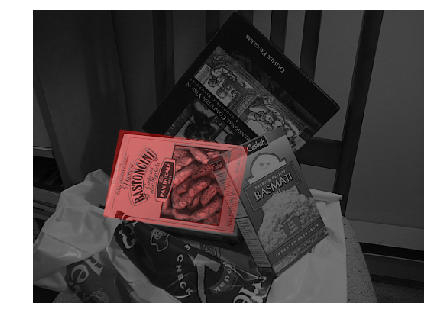

In [66]:
plt.figure(figsize=(7,7))
plt.imshow(out)
plt.axis('off')

The result is quite good, but because the actual mapping between the images is nonlinear, affine transformation cannot fully explain the mapping, and we can see some misalignment especially around the upper left corner of the template.